In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import seaborn as sns
from typing import List
import timeit
import warnings
warnings.filterwarnings("ignore")

In [ ]:
class activations:
    _z = None
    _a = None

    # Sigmoid activation function
    @staticmethod
    def sigmoid():
        y = 1 / (1 + np.exp(-activations._z))
        return y

    # Derivative of sigmoid
    @staticmethod
    def sigmoid_der():
        y = activations._a * (1 - activations._a)
        return y

    # Tanh activation function
    @staticmethod
    def tanh():
        y = (np.exp(activations._z) - np.exp(-activations._z)) / (np.exp(activations._z) + np.exp(-activations._z))
        return y

    # Derivative of tanh
    @staticmethod
    def tanh_der():
        y = 1 - activations._a ** 2
        return y

    # Relu activation function
    @staticmethod
    def relu():
        y = np.maximum(0, activations._z)
        return y

    # derivative of relu
    @staticmethod
    def relu_der():
        activations._a[activations._a <= 0] = 0
        activations._a[activations._a > 0] = 1
        return activations._a


    # Softmax activation function
    @staticmethod
    def softmax():
        y = np.exp(activations._z) / np.sum(np.exp(activations._z), axis=0)
        return y


In [ ]:
class losses:

    @staticmethod
    def MeanSquaredError(y_true, y_predict, k):
        return (1 / k) * np.sum((y_true - y_predict)**2)

    @staticmethod
    def MeanSquaredErrorBackProp(y_true, y_predict):
        dZ_last = 2*(y_true - y_predict)
        return dZ_last

    @staticmethod
    def BinaryCrossentropy(y_true, y_predict, k):
        return (-1) * (1 / k) * (np.sum((y_true * np.log(y_predict + 1e-8)) +
                                        ((1 - y_true) * (np.log(1 - y_predict + 1e-8)))))
    @staticmethod
    def BinaryCrossentropyBackProp(y_true, y_predict):
        dZ_last = (y_predict - y_true)
        return dZ_last

    @staticmethod
    def CategoricalCrossentropy(y_true, y_predict, k):
        return (-1) * (1 / k) * np.sum((y_true * np.log(y_predict)))

    @staticmethod
    def CategoricalCrossentropyBackProp(y_true, y_predict):
        dZ_last = (y_predict - y_true)
        return dZ_last


In [ ]:
class initializers:
    _present_layer_size = None
    _previous_layer_size = None

    @staticmethod
    def Zeros():
        W = np.zeros((initializers._present_layer_size, initializers._previous_layer_size))
        b = np.zeros((initializers._present_layer_size, 1))
        return W, b

    @staticmethod
    def Ones():
        W = np.ones((initializers._present_layer_size, initializers._previous_layer_size))
        b = np.ones((initializers._present_layer_size, 1))
        return W, b

    # Weights initialization for relu
    @staticmethod
    def He():
        np.random.seed(0)
        W = np.random.randn(initializers._present_layer_size, initializers._previous_layer_size)*np.sqrt(2/initializers._previous_layer_size)
        b = np.zeros((initializers._present_layer_size, 1))
        return W, b

    # Weights initializtion for sigmoid/tanh
    @staticmethod
    def Xavier():
        np.random.seed(0)
        W = np.random.randn(initializers._present_layer_size, initializers._previous_layer_size)*np.sqrt(1/initializers._previous_layer_size)
        b = np.zeros((initializers._present_layer_size, 1))
        return W, b


In [ ]:
class optimizers:
    _lr= None
    selected_optimizer = None


    @staticmethod
    def SGD(W, b, dW, db, lr=0.01):
        lr_ = 0
        if optimizers._lr != None:
            lr_ = optimizers._lr
        else:
            lr_ = lr
        for layer in range(1, len(W)+1):
            W["W_"+str(layer)] -= lr_ * dW["dW_"+str(layer)]
            b["b_"+str(layer)] -= lr_ * db["db_"+str(layer)]
        return {"W": W, "b": b}


    @staticmethod
    def Momentum(W, b, dW, db, VdW, Vdb, lr=0.01, beta=0.9):
        lr_ = 0
        if optimizers._lr != None:
            lr_ = optimizers._lr
        else:
            lr_ = lr
        for layer in range(1, len(W)+1):
            VdW["VdW_"+str(layer)] = beta * VdW["VdW_"+str(layer)] + (1 - beta) * dW["dW_"+str(layer)]
            Vdb["Vdb_"+str(layer)] = beta * Vdb["Vdb_"+str(layer)] + (1 - beta) * db["db_"+str(layer)]
            W["W_"+str(layer)] -= lr_ * VdW["VdW_"+str(layer)]
            b["b_"+str(layer)] -= lr_ * Vdb["Vdb_"+str(layer)]
        return {"W": W, "b": b, "VdW": VdW, "Vdb": Vdb}

    @staticmethod
    def NAG(W, b, dW, db, VdW, Vdb, W_present, b_present, dW_future=None, db_future=None, lr=1, beta=0.9, look_ahead=True):
        lr_ = 0
        if optimizers.lr != None:
            lr_ = optimizers._lr
        else:
            lr_ = lr

        W_future = {}
        b_future = {}
        if look_ahead:
            for layer in range(1, len(W)+1):
                W_future["Wf_"+str(layer)] = W_present["W_"+str(layer)] - beta * VdW["VdW_"+str(layer)]
                b_future["bf_"+str(layer)] = b_present["b_"+str(layer)] - beta * Vdb["Vdb_"+str(layer)]
            return {"W_future": W_future, "b_future": b_future}
        else:
            for layer in range(1, len(W)+1):
                VdW["VdW_"+str(layer)] = beta * VdW["VdW_"+str(layer)] + (1 - beta) * dW_future["dW_"+str(layer)]
                Vdb["Vdb_"+str(layer)] = beta * Vdb["Vdb_"+str(layer)] + (1 - beta) * db_future["db_"+str(layer)]
                W["W_"+str(layer)] = W_present["W_"+str(layer)] - lr_ * VdW["VdW_"+str(layer)]
                b["b_"+str(layer)] = b_present["b_"+str(layer)] - lr_ * Vdb["Vdb_"+str(layer)]
            return {"W": W, "b": b, "VdW": VdW, "Vdb": Vdb}


    @staticmethod
    def Adagrad(W, b, dW, db, V_W, V_b, lr_W, lr_b, lr=0.01, fuzz_factor=1e-08):
        lr_ = 0
        if optimizers._lr != None:
            lr_ = optimizers._lr
        else:
            lr_ = lr
        for layer in range(1, len(W)+1):
            V_W["V_W_"+str(layer)] = V_W["V_W_"+str(layer)] + dW["dW_"+str(layer)]**2
            V_b["V_b_"+str(layer)] = V_b["V_b_"+str(layer)] + db["db_"+str(layer)]**2
            lr_W["lr_W"+str(layer)] = lr_ / np.sqrt(V_W["V_W_"+str(layer)] + fuzz_factor)
            lr_b["lr_b"+str(layer)] = lr_ / np.sqrt(V_b["V_b_"+str(layer)] + fuzz_factor)
            W["W_"+str(layer)] -= lr_W["lr_W"+str(layer)] * dW["dW_"+str(layer)]
            b["b_"+str(layer)] -= lr_b["lr_b"+str(layer)] * db["db_"+str(layer)]
        return {"W": W, "b": b, "V_W": V_W, "V_b": V_b, "lr_W": lr_W, "lr_b": lr_b}


    @staticmethod
    def RMSprop(W, b, dW, db, SdW, Sdb, lr_W, lr_b, lr=0.01, beta=0.9, fuzz_factor=1e-08):
        lr_ = 0
        if optimizers._lr != None:
            lr_ = optimizers._lr
        else:
            lr_ = lr
        for layer in range(1, len(W)+1):
            SdW["SdW_"+str(layer)] = beta * SdW["SdW_"+str(layer)] + (1 - beta) * dW["dW_"+str(layer)]**2
            Sdb["Sdb_"+str(layer)] = beta * Sdb["Sdb_"+str(layer)] + (1 - beta) * db["db_"+str(layer)]**2
            lr_W["lr_W"+str(layer)] = lr_ / np.sqrt(SdW["SdW_"+str(layer)] + fuzz_factor)
            lr_b["lr_b"+str(layer)] = lr_ / np.sqrt(Sdb["Sdb_"+str(layer)] + fuzz_factor)
            W["W_"+str(layer)] -= lr_ * dW["dW_"+str(layer)]
            b["b_"+str(layer)] -= lr_ * db["db_"+str(layer)]
        return {"W": W, "b": b, "SdW": SdW, "Sdb": Sdb, "lr_W": lr_W, "lr_b": lr_b}


    @staticmethod
    def Adadelta(W, b, dW, db, W_past, b_past, D_W, D_b, SdW, Sdb, delta_W,  delta_b, lr_W, lr_b, lr=0.01, beta=0.9, fuzz_factor=1e-08):
        lr_ = 0
        if optimizers._lr != None:
            lr_ = optimizers._lr
        else:
            lr_ = lr
        for layer in range(1, len(W)+1):
            delta_W["delta_W"+str(layer)] = W["W_"+str(layer)] - W_past["W_"+str(layer)]
            delta_b["delta_b"+str(layer)] = b["b_"+str(layer)] - b_past["b_"+str(layer)]
            D_W["D_W_"+str(layer)] = beta * D_W["D_W_"+str(layer)] + (1-beta) * delta_W["delta_W"+str(layer)]**2
            D_b["D_b_"+str(layer)] = beta * D_b["D_b_"+str(layer)] + (1-beta) * delta_b["delta_b"+str(layer)]**2
            SdW["SdW_"+str(layer)] = beta * SdW["SdW_"+str(layer)] + (1 - beta) * dW["dW_"+str(layer)]**2
            Sdb["Sdb_"+str(layer)] = beta * Sdb["Sdb_"+str(layer)] + (1 - beta) * db["db_"+str(layer)]**2
            lr_W["lr_W"+str(layer)] = np.sqrt(D_W["D_W_"+str(layer)] + fuzz_factor) / np.sqrt(SdW["SdW_"+str(layer)] + fuzz_factor)
            lr_b["lr_b"+str(layer)] = np.sqrt(D_b["D_b_"+str(layer)] + fuzz_factor) / np.sqrt(Sdb["Sdb_"+str(layer)] + fuzz_factor)
            W["W_"+str(layer)] -= lr_W["lr_W"+str(layer)] * dW["dW_"+str(layer)]
            b["b_"+str(layer)] -= lr_b["lr_b"+str(layer)] * db["db_"+str(layer)]
        return  {"W": W, "b": b, "W_past": W_past, "b_past": b_past, "D_W": D_W, "D_b": D_b, "SdW": SdW, "Sdb": Sdb, "lr_W": lr_W, "lr_b": lr_b}



    @staticmethod
    def Adam(W, b, dW, db, VdW, Vdb, SdW, Sdb, t, lr=0.001, beta_1=0.9, beta_2=0.999, fuzz_factor=1e-08):
        lr_ = 0
        if optimizers._lr != None:
            lr_ = optimizers._lr
        else:
            lr_ = lr
        for layer in range(1, len(W)+1):
            VdW["VdW_"+str(layer)] = beta_1 * VdW["VdW_"+str(layer)] + (1 - beta_1) * dW["dW_"+str(layer)]
            Vdb["Vdb_"+str(layer)] = beta_1 * Vdb["Vdb_"+str(layer)] + (1 - beta_1) * db["db_"+str(layer)]
            SdW["SdW_"+str(layer)] = beta_2 * SdW["SdW_"+str(layer)] + (1 - beta_2) * dW["dW_"+str(layer)]**2
            Sdb["Sdb_"+str(layer)] = beta_2 * Sdb["Sdb_"+str(layer)] + (1 - beta_2) * db["db_"+str(layer)]**2
            W["W_"+str(layer)] -= (lr_ / np.sqrt(SdW["SdW_"+str(layer)]  + fuzz_factor)) * VdW["VdW_"+str(layer)]
            b["b_"+str(layer)] -= (lr_ / np.sqrt(Sdb["Sdb_"+str(layer)]  + fuzz_factor)) * Vdb["Vdb_"+str(layer)]
        return {"W": W, "b": b, "VdW": VdW, "Vdb": Vdb, "SdW": SdW, "Sdb": Sdb}




In [ ]:
class layers:

    @staticmethod
    def Dense(layer_nodes:int, activation:str=None, kernel_initializer:str="He", kernel_regularizer= None, input_shape:int=None):
        return {"layer_nodes":layer_nodes, "activation":activation, "kernel_initializer":kernel_initializer, "input_shape":input_shape}


    @staticmethod
    def Dropout(keep_prob:float=0.8):
        return {"layer_nodes":None, "activation":None, "kernel_initializer":"He", "input_shape":None, "keep_prob": keep_prob}

In [ ]:
class Sequential:

    def __init__(self):
        self.W = {}; self.b = {}
        self.A = {}; self.Z = {}
        self.VdW = {}; self.Vdb = {}
        self.SdW = {}; self.Sdb = {}
        self.V_W = {}; self.V_b = {}
        self.D_W = {}; self.D_b = {}
        self.lr_W = {}; self.lr_b = {}
        self.W_past = {}; self.b_past = {}
        self.loss = None
        self.count = 0
        self.__layers_list = []
        self.loss_per_epoch = []
        self.history = {"acc": [], "loss": [], "val_acc": [], "val_loss": []}
        self.optimizers_list = ["GD", "SGD", "momentum", "NAG", "adagrad", "adadelta", "rmsprop", "adam", None]
        self.activations = ["sigmoid", "softmax", "relu", "tanh"]
        self.losses = ["mse", "binary_crossentropy", "categorical_crossentropy"]
        self.weights_init = ["ones", "zeros", "He", "Xavier"]
        self.metric = None
        self.metrics_list = ["accuracy", "R2_score", "mse", "rmse", "mae"]


    @property
    def layers_list(self):
        layers = self.__layers_list
        layers_updated = []
        for layer in layers:
            if "keep_prob" in layer:
                del layers_updated[-1]
            layers_updated.append(layer)
        return layers_updated


    def add(self, layer):
        self.__layers_list.append(layer)
        seq = self.__layers_list

        if seq[0]["input_shape"] == None:
            raise Exception(f"First Dense() keyword argument 'input_shape' must be assigned a value")

        if "keep_prob" in seq[self.count]:
            seq[self.count]["input_shape"] = seq[self.count-1]["input_shape"]
            seq[self.count]["activation"] = seq[self.count-1]["activation"]
            seq[self.count]["layer_nodes"] = seq[self.count-1]["layer_nodes"]
            seq[self.count]["kernel_initializer"] = seq[self.count-1]["kernel_initializer"]

        if seq[self.count]["input_shape"] == None:
            seq[self.count]["input_shape"] = seq[self.count-1]["layer_nodes"]

        if seq[self.count]["kernel_initializer"] not in self.weights_init:
            raise Exception(f"Error: Dense() got an expected keyword argument '{seq[self.count]['kernel_initializer']}' ")

        if seq[self.count]["activation"] not in self.activations:
            raise Exception(f"Error: Dense() got an expected keyword argument '{seq[self.count]['activation']}' ")

        self.count += 1


    def compile(self, optimizer:str=None, lr:float=None, loss:str=None, metric:str="accuracy"):
        if loss == None:
            raise Exception(f"Compile keyword argument 'loss' must be assigned a value")

        if loss in self.losses:
            self.loss = loss
        else:
            raise Exception(f"Error: compile got an unexpected keyword argument '{loss}' ")

        if metric != None:
            if metric not in self.metrics_list:
                raise Exception(f"Error: wrong item(s) in keyword argument 'metric'.")
        else:
            self.metric = metric

        if optimizer not in self.optimizers_list:
            raise Exception(f"Error: compile got an unexpected keyword argument '{optimizer}' ")

        else:
            optimizers.selected_optimizer = optimizer

        self.metric = metric
        optimizers._lr = lr


    def fit(self, x_train, y_train, epochs:int=50, batch_size:int=16, validation_data=None, shuffle=True):
        self.x_train = x_train
        self.y_train = y_train
        self.validation_data = validation_data
        self.epochs = epochs
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.validation_data = validation_data

        layers = self.layers_list

        #Initialization
        for i in range(1, len(layers)+1):

            initializers._present_layer_size = layers[i-1]["layer_nodes"]
            initializers._previous_layer_size = layers[i-1]["input_shape"]

            if layers[i-1]["kernel_initializer"] == "He":
                kernel = initializers.He()
                self.W["W_"+str(i)] = kernel[0]; self.b["b_"+str(i)] = kernel[1]

            if layers[i-1]["kernel_initializer"] == "Xavier":
                kernel = initializers.Xavier()
                self.W["W_"+str(i)] = kernel[0]; self.b["b_"+str(i)] = kernel[1]

            if layers[i-1]["kernel_initializer"] == "zeros":
                kernel = initializers.Zeros()
                self.W["W_"+str(i)] = kernel[0]; self.b["b_"+str(i)] = kernel[1]

            if layers[i-1]["kernel_initializer"] == "ones":
                kernel = initializers.Ones()
                self.W["W_"+str(i)] = kernel[0]; self.b["b_"+str(i)] = kernel[1]

            self.VdW["VdW_"+str(i)] = np.zeros((initializers._present_layer_size, initializers._previous_layer_size))
            self.Vdb["Vdb_"+str(i)] = initializers.He()[1]
            self.SdW["SdW_"+str(i)] = np.zeros((initializers._present_layer_size, initializers._previous_layer_size))
            self.Sdb["Sdb_"+str(i)] = initializers.He()[1]
            self.V_W["V_W_"+str(i)] = np.zeros((initializers._present_layer_size, initializers._previous_layer_size))
            self.V_b["V_b_"+str(i)] = initializers.He()[1]
            self.D_W["D_W_"+str(i)] = np.zeros((initializers._present_layer_size, initializers._previous_layer_size))
            self.D_b["D_b_"+str(i)] = initializers.He()[1]
            self.W_past["W_"+str(i)] = np.zeros((initializers._present_layer_size, initializers._previous_layer_size))
            self.b_past["b_"+str(i)] = initializers.He()[1]

        if self.metric == "r2_score":
          self.__change_metric("acc", "r2_score")
          self.__change_metric("val_acc", "val_r2_score")

        if self.metric == "rmse":
          self.__change_metric("acc", "rmse")
          self.__change_metric("val_acc", "val_rmse")

        if self.metric == "mae":
            self.__change_metric("acc", "mae")
            self.__change_metric("val_acc", "val_mae")

        if self.metric == "mse":
          self.__change_metric("acc", "mse")
          self.__change_metric("val_acc", "val_mse")

        # iterate over training epochs
        for epoch in range(self.epochs):

            if self.shuffle:
                XY_concat = np.concatenate((self.x_train, self.y_train), axis=1)
                indices = np.arange(XY_concat.shape[0])
                np.random.shuffle(indices)
                XY_concat_ = np.zeros((XY_concat.shape[0], XY_concat.shape[-1]))
                for idx in range(XY_concat.shape[0]):
                    XY_concat_[indices[idx]] = list(XY_concat[idx])
                self.x_train = XY_concat_[:, :self.x_train.shape[-1]]
                self.y_train  = XY_concat_[:, self.x_train.shape[-1]:]

            print(f"Epoch {epoch+1}/{self.epochs}")

            self.__train()

            #Validation
            if self.validation_data != None:
                validate = self.evaluate(self.validation_data[0], self.validation_data[1], _evaluating=False)
                self.history["val_loss"].append(validate[0])

                if self.metric == "accuracy":
                  self.history["val_acc"].append(validate[1])

                if self.metric == "r2_score":
                  self.history["val_r2_score"].append(validate[0])

                if self.metric == "rmse":
                  self.history["val_rmse"].append(validate[0])

                if self.metric == "mae":
                  self.history["val_mae"].append(validate[0])

                if self.metric == "mse":
                  self.history["val_mse"].append(validate[0])


    def __train(self):

        m = self.x_train.shape[0]  #number of training examples
        self.n = m // self.batch_size # number of minibatches
        if m % self.batch_size > 0:
            self.n += 1
        A = self.A; Z = self.Z
        W = self.W; b = self.b
        layers = self.layers_list
        loss_per_iter = [] #losses of all the batches
        Y_pred = [] #prediction of all the batches
        D = {}; keep_prob = {} #use for dropout computation

        start_time = timeit.default_timer()
        for batch in range(self.n):
            """__________Forward Propagation____________"""

            x_batch = self.x_train[batch * self.batch_size:(batch+1) * self.batch_size].T
            y_batch = self.y_train[batch * self.batch_size:(batch+1) * self.batch_size].T
            A["A_"+str(0)] = x_batch # Input layer

            for layer in range(1, len(W)+1):
                Z["Z_"+str(layer)] = np.dot(W["W_"+str(layer)], A["A_"+str(layer-1)]) + b["b_"+str(layer)]
                activations._z = Z["Z_"+str(layer)]

                if layers[layer-1]["activation"] == None:
                    A["A_"+str(layer)] = Z["Z_"+str(layer)]

                if layers[layer-1]["activation"] == "sigmoid":
                    A["A_"+str(layer)] = activations.sigmoid()

                if layers[layer-1]["activation"] == "tanh":
                    A["A_"+str(layer)] = activations.tanh()

                if layers[layer-1]["activation"] == "relu":
                    A["A_"+str(layer)] = activations.relu()

                if layers[layer-1]["activation"] == "softmax":
                    A["A_"+str(layer)] = activations.softmax()

                # Dropout
                if "keep_prob" in layers[layer-1]:
                    keep_prob["kp"+str(layer)] = layers[layer-1]["keep_prob"]
                    D["D_"+str(layer)] = np.random.rand(A["A_"+str(layer)].shape[0], A["A_"+str(layer)].shape[1]) < keep_prob["kp"+str(layer)]
                    #inverted dropout technique
                    A["A_"+str(layer)] *= D["D_"+str(layer)] / keep_prob["kp"+str(layer)]

            #Loss computation
            y_true = y_batch
            y_predict = A["A_"+str(len(W))] #activation of the output layer
            k_ = x_batch.shape[1]
            loss = self.loss
            if loss == "mse":
                loss_per_iter.append(losses.MeanSquaredError(y_true, y_predict, k_))

            elif loss == "binary_crossentropy":
                loss_per_iter.append(losses.BinaryCrossentropy(y_true, y_predict, k_))

            elif loss == "categorical_crossentropy":
                loss_per_iter.append(losses.CategoricalCrossentropy(y_true, y_predict, k_))

            """___________Back propagation________________"""

            dZ = {"dZ_"+str(i):np.zeros(Z["Z_"+str(i)].shape) for i in range(1, len(Z)+1)}
            dW = {}; db = {}
            W_present = W
            b_present = b
            if optimizers.selected_optimizer == "NAG":
                optimize = optimizers.NAG(W, b, dW, db, self.VdW, self.Vdb, W_present, b_present)
                W_future = optimize["W_future"]
                b_future = optimize["b_future"]

                #Make W and b to be equal to W_future=W + beta * VdW and b_future=b + beta * Vdb respectively.
                for i in range(1, len(W)+1):
                    W["W_"+str(i)] = W_future["Wf_"+str(i)]
                    b["b_"+str(i)] = b_future["bf_"+str(i)]

            if loss == "mse":
                dZ[list(dZ.keys())[-1]] = losses.MeanSquaredErrorBackProp(y_true, y_predict) #last layer dZ

            elif loss == "binary_crossentropy":
                dZ[list(dZ.keys())[-1]] = losses.BinaryCrossentropyBackProp(y_true, y_predict)  #last layer dZ

            elif loss == "categorical_crossentropy":
                dZ[list(dZ.keys())[-1]] = losses.CategoricalCrossentropyBackProp(y_true, y_predict)  #last layer dZ

            #Previous layers dZ computation
            prev_layers_ = list(range(1, len(dZ)))
            prev_layers_.reverse()

            for j in prev_layers_:
                activations._a = A["A_"+str(j)]
                layer_activation = layers[j-1]["activation"]
                dA = np.dot(W["W_"+str(j+1)].T, dZ["dZ_"+str(j+1)])

                if "kp"+str(j) in keep_prob:
                    dA *= D["D_"+str(j)] / keep_prob["kp"+str(j)]

                if layer_activation == None:
                    dZ["dZ_"+str(j)] = dA * 1

                elif layer_activation == "sigmoid":
                    dZ["dZ_"+str(j)] = dA * activations.sigmoid_der()

                elif layer_activation == "relu":
                    dZ["dZ_"+str(j)] = dA * activations.relu_der()

                elif layer_activation == "tanh":
                    dZ["dZ_"+str(j)] = dA * activations.tanh_der()

            for l in range(1, len(W)+1):
                dW["dW_"+str(l)] = np.dot(dZ["dZ_"+str(l)], A["A_"+str(l-1)].T) / k_
                db["db_"+str(l)] = np.sum(dZ["dZ_"+str(l)], axis=1, keepdims=True) / k_


            if optimizers.selected_optimizer == "NAG":
                dW_future_ = dW
                db_future_ = db
                optimize = optimizers.NAG(W, b, dW, db, self.VdW, self.Vdb, W_present, b_present, dW_future=dW_future_, db_future=db_future_, look_ahead=False)
                W = optimize["W"]; b = optimize["b"]
                self.VdW = optimize["VdW"]; self.Vdb = optimize["Vdb"]


            if optimizers.selected_optimizer == "SGD":
                optimize = optimizers.SGD(W, b, dW, db)
                W = optimize["W"]; b = optimize["b"]

            if optimizers.selected_optimizer == "momentum":
                optimize = optimizers.Momentum(W, b, dW, db, self.VdW, self.Vdb)
                W = optimize["W"]; b = optimize["b"]
                VdW = optimize["VdW"]; Vdb = optimize["Vdb"]

            if optimizers.selected_optimizer == "adagrad":
                optimize = optimizers.Adagrad(W, b, dW, db, self.V_W, self.V_b, self.lr_W, self.lr_b)
                W = optimize["W"]; b = optimize["b"]
                self.V_W = optimize["V_W"]; self.V_b = optimize["V_b"]
                self.lr_W = optimize["lr_W"]; self.lr_b = optimize["lr_b"]

            if optimizers.selected_optimizer == "rmsprop":
                optimize = optimizers.RMSprop(W, b, dW, db, self.SdW, self.Sdb, self.lr_W, self.lr_b)
                W = optimize["W"]; b = optimize["b"]
                self.SdW = optimize["SdW"]; self.Sdb = optimize["Sdb"]
                self.lr_W = optimize["lr_W"]; self.lr_b = optimize["lr_b"]

            if optimizers.selected_optimizer == "adadelta":
                delta_W = {}; delta_b = {}
                optimize = optimizers.Adadelta(W, b, dW, db, self.W_past, self.b_past, self.D_W, self.D_b, self.SdW, self.Sdb, delta_W, delta_b, self.lr_W, self.lr_b)
                self.W_past = W; self.b_past=b
                W = optimize["W"]; b = optimize["b"]
                self.SdW = optimize["SdW"]; self.Sdb = optimize["Sdb"]
                self.D_W = optimize["D_W"]; self.D_b = optimize["D_b"]
                self.lr_W = optimize["lr_W"]; self.lr_b = optimize["lr_b"]

            if optimizers.selected_optimizer == "adam":
                optimize  = optimizers.Adam(W, b, dW, db, self.VdW, self.Vdb, self.SdW, self.Sdb, batch+1)
                W = optimize["W"]; b = optimize["b"]
                self.VdW = optimize["VdW"]; self.Vdb = optimize["Vdb"]
                self.SdW = optimize["SdW"]; self.Sdb = optimize["Sdb"]

            y_pred = A["A_"+str(len(W))] #activation of the output layer
            Y_pred.append(y_pred.T)

        self.W = W; self.b = b
        Y_pred = np.concatenate(Y_pred, axis=0)

        #Calculating the metric of the training data per epoch
        metric_value = 0
        if self.metric == "accuracy":
            training_acc = self.__accuracy(self.y_train, Y_pred)
            self.history["acc"].append(training_acc)
            metric_value = training_acc

        if self.metric == "r2_score":
            training_score = self.__R2_score(self.y_train, Y_pred)
            self.history["r2_score"].append(training_score)
            metric_value = training_score

        if self.metric == "rmse":
            training_rmse = self.__RMSE(self.y_train, Y_pred)
            self.history["rmse"].append(training_rmse)
            metric_value = training_rmse


        if self.metric == "mae":
            training_mae = self.__MAE(self.y_train, Y_pred)
            self.history["mae"].append(training_mae)
            metric_value = training_mae

        if self.metric == "mse":
            training_mse = self.__MSE(self.y_train, Y_pred)
            self.history["mse"].append(training_rmse)
            metric_value = training_mse

        avg_loss_per_epoch = sum(loss_per_iter)/len(loss_per_iter)
        self.history["loss"].append(avg_loss_per_epoch) #loss per epoch
        loss_per_iter.clear()

        end_time = timeit.default_timer()
        runtime = end_time - start_time
        print(f"{Y_pred.shape[0]}/{self.y_train.shape[0]} [==============================] runtime: {np.round_(runtime, 4)}s, loss:{np.round_(avg_loss_per_epoch, 4)}, {self.metric}: {np.round_(metric_value, 4)} ")
        print()

    def __change_metric(self, old_metric, new_metric):
      del self.history[old_metric]
      self.history[new_metric] = []


    def evaluate(self, x, y, _evaluating=True):
        p = x.shape[0]  #number of testing examples
        self.n = p // self.batch_size # number of minibatches
        if p % self.batch_size > 0:
            self.n += 1
        layers = self.layers_list
        W = self.W; b = self.b
        A = {}; Z = {}
        results = [] #loss and accuracy
        Y_predicted = [] #all the predicted y values
        loss_per_batch = []

        start = timeit.default_timer()
        for batch in range(self.n):
            x_batch = x[batch * self.batch_size:(batch+1) * self.batch_size].T
            y_batch = y[batch * self.batch_size:(batch+1) * self.batch_size].T
            A["A_"+str(0)] = x_batch # Input layer

            for layer in range(1, len(W)+1):
                Z["Z_"+str(layer)] = np.dot(W["W_"+str(layer)], A["A_"+str(layer-1)]) + b["b_"+str(layer)]
                activations._z = Z["Z_"+str(layer)]
                if layers[layer-1]["activation"] == None:
                    A["A_"+str(layer)] = Z["Z_"+str(layer)]

                if layers[layer-1]["activation"] == "sigmoid":
                    A["A_"+str(layer)] = activations.sigmoid()

                if layers[layer-1]["activation"] == "tanh":
                    A["A_"+str(layer)] = activations.tanh()

                if layers[layer-1]["activation"] == "relu":
                    A["A_"+str(layer)] = activations.relu()

                if layers[layer-1]["activation"] == "softmax":
                    A["A_"+str(layer)] = activations.softmax()

            y_true = y_batch
            y_predict = A["A_"+str(len(W))] #activation of the output layer
            Y_predicted.append(y_predict.T)
            k_ = x_batch.shape[1]
            loss = self.loss

            #Loss computation
            if loss == "mse":
                loss_per_batch.append(losses.MeanSquaredError(y_true, y_predict, k_))

            elif loss == "binary_crossentropy":
                loss_per_batch.append(losses.BinaryCrossentropy(y_true, y_predict, k_))

            elif loss == "categorical_crossentropy":
                loss_per_batch.append(losses.CategoricalCrossentropy(y_true, y_predict, k_))
        end=timeit.default_timer()
        runtime = end-start

        Y_predicted = np.concatenate(Y_predicted, axis=0)
        metric_value = 0

        if self.metric == "accuracy":
          metric_value = self.__accuracy(y, Y_predicted)

        if self.metric == "r2_score":
          metric_value = self.__R2_score(y, Y_predicted)

        if self.metric == "rmse":
          metric_value = self.__RMSE(y, Y_predicted)

        if self.metric == "mae":
          metric_value = self.__MAE(y, Y_predicted)

        if self.metric == "mse":
          metric_value = self.__MSE(y, Y_predicted)

        results.append(sum(loss_per_batch)/len(loss_per_batch)) #evaluation loss
        results.append(metric_value)

        if _evaluating:
            print(f"{Y_predicted.shape[0]}/{y.shape[0]} [==============================] runtime: {np.round_(runtime, 4)}s, loss:{np.round_(results[0], 4)}, {self.metric}: {np.round_(results[-1], 4)}\n{results}")
            return
        else:
            return results


    def __accuracy(self, y_true, y_predict):
        acc = np.mean(np.equal(np.argmax(y_true, axis=-1), np.argmax(y_predict, axis=-1)))
        return acc


    def __RMSE(self, y_true, y_predict):
      rmse = np.sqrt(np.mean((y_true - y_predict)**2))
      return rmse

    def __R2_score(self, y_true, y_predict):
      rss = np.sum((y_true-y_predict)**2)
      tss = np.sum((y_true-np.mean(y_true))**2)
      r2_score = 1-(rss/tss)
      return r2_score


    def __MAE(self, y_true, y_predict):
      mae = np.mean(np.abs(y_true - y_predict))
      return mae

    def __MSE(self, y_true, y_predict):
      mse = np.mean((y_true - y_predict) ** 2)
      return mse


    def predict(self, x_test):
        layers = Sequential.layers
        W = self.W; b = self.b
        A = {}; Z = {}
        A["A_"+str(0)] = x_test.T
        for layer in range(1, len(W)+1):
            Z["Z_"+str(layer)] = np.dot(W["W_"+str(layer)], A["A_"+str(layer-1)]) + b["b_"+str(layer)]
            activations._z = Z["Z_"+str(layer)]
            if layers[layer-1]["activation"] == None:
                A["A_"+str(layer)] = Z["Z_"+str(layer)]

            if layers[layer-1]["activation"] == "sigmoid":
                A["A_"+str(layer)] = activations.sigmoid()

            if layers[layer-1]["activation"] == "tanh":
                A["A_"+str(layer)] = activations.tanh()

            if layers[layer-1]["activation"] == "relu":
                A["A_"+str(layer)] = activations.relu()

            if layers[layer-1]["activation"] == "softmax":
                A["A_"+str(layer)] = activations.softmax()
        y_predicted = A["A_"+str(len(W))].T #activation of the output layer
        return y_predicted






In [ ]:
#Loading MNIST training and testing dataset
(train_images, train_labels) , (test_images, test_labels) = keras.datasets.mnist.load_data()

In [ ]:
print(train_images.shape,"   ", train_labels.shape)

(60000, 28, 28)     (60000,)


In [ ]:
print(test_images.shape,"   ", test_labels.shape)

(10000, 28, 28)     (10000,)


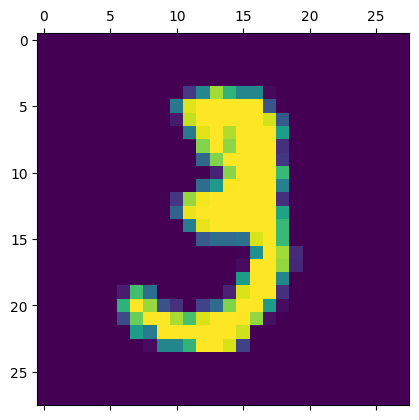

In [73]:
plt.matshow(train_images[10])

In [74]:
train_images[10]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 118,
        219, 166, 118, 118,   6,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 103, 242, 254,
        254, 254, 254, 254,  66,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

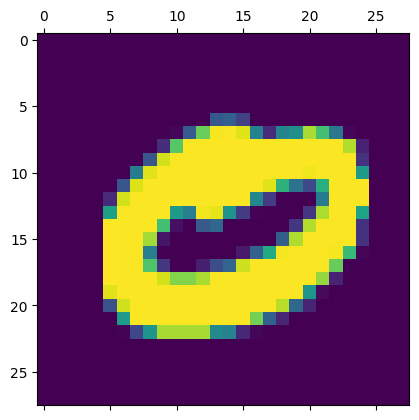

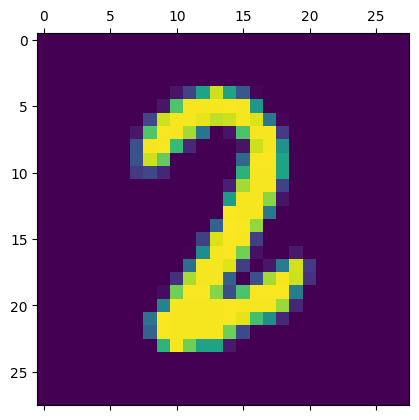

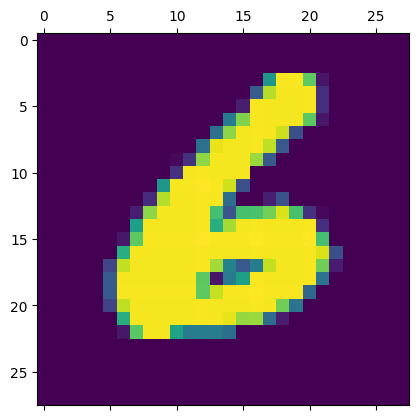

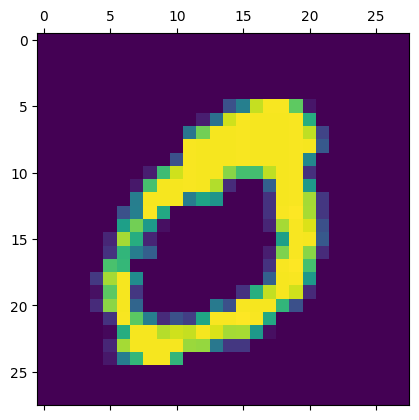

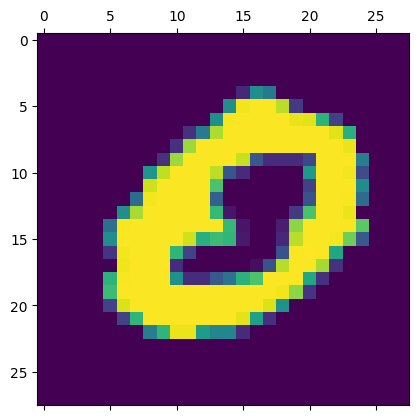

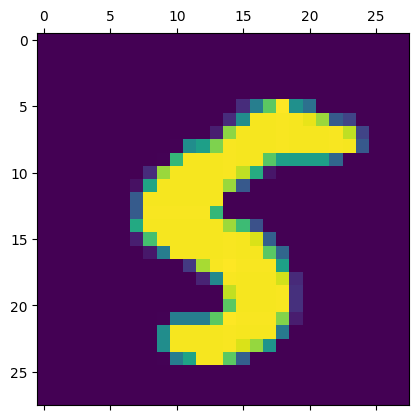

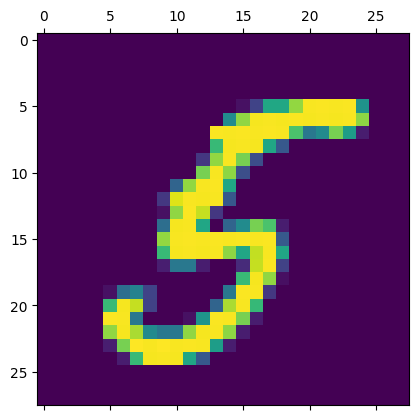

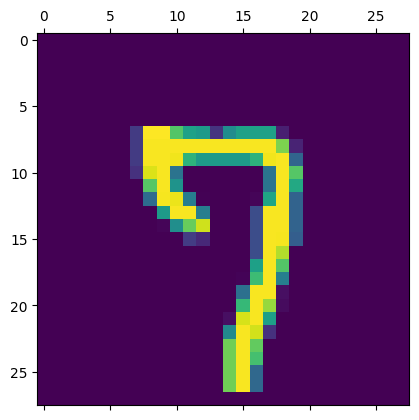

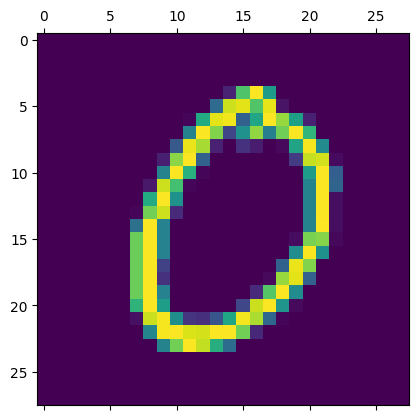

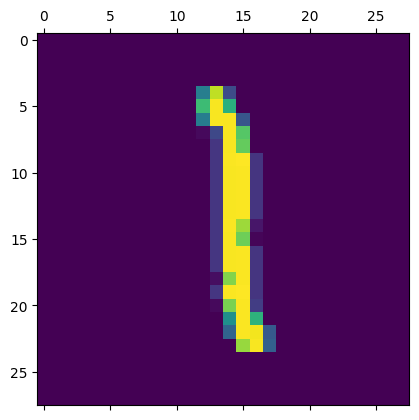

In [ ]:
# randomly select 10 images and display
labels = []
for idx in np.random.randint(0,60000, size=10):
  labels.append(train_labels[idx])
  plt.matshow(train_images[idx])




In [ ]:
print(f"Labels of the randamly selected 10 images:\n {labels}")

Labels of the randamly selected 10 images:
 [0, 2, 6, 0, 0, 5, 5, 7, 0, 1]


In [ ]:
# validation data
val_images = train_images[: 10000]; val_labels = train_labels[: 10000]

# data use for training
partial_train_images = train_images[10000:]; partial_train_labels = train_labels[10000:]

In [ ]:

#------------Preparing the image data--------------

train_images_flattened = train_images.reshape(len(train_images), train_images.shape[1] * train_images.shape[2])
train_images_flattened = train_images_flattened.astype("float32") / np.max(train_images_flattened)

partial_train_images_flattened = partial_train_images.reshape(len(partial_train_images), partial_train_images.shape[1] * partial_train_images.shape[2])
partial_train_images_flattened = partial_train_images_flattened.astype("float32") / np.max(partial_train_images_flattened)

val_images_flattened = val_images.reshape(len(val_images), val_images.shape[1] * val_images.shape[2])
val_images_flattened = val_images_flattened.astype("float32") / np.max(val_images_flattened)

test_images_flattened = test_images.reshape(len(test_images), test_images.shape[1] * test_images.shape[2])
test_images_flattened = test_images_flattened.astype("float32") / np.max(test_images_flattened)

# one hot encode the features
one_hot_train_labels = np.zeros((train_labels.shape[0], np.unique(train_labels).shape[0]))
one_hot_partial_train_labels = np.zeros((partial_train_labels.shape[0], np.unique(train_labels).shape[0]))
one_hot_val_labels = np.zeros((val_labels.shape[0], np.unique(train_labels).shape[0]))
one_hot_test_labels = np.zeros((test_labels.shape[0], np.unique(train_labels).shape[0]))

for i in range(one_hot_train_labels.shape[0]):
  one_hot_train_labels[i, train_labels[i]] = 1

for i in range(one_hot_partial_train_labels.shape[0]):
  one_hot_partial_train_labels[i, partial_train_labels[i]] = 1

for i in range(one_hot_val_labels.shape[0]):
  one_hot_val_labels[i, val_labels[i]] = 1

for i in range(one_hot_test_labels.shape[0]):
  one_hot_test_labels[i, test_labels[i]] = 1

print(f"X_train shape: {partial_train_images_flattened.shape}, y_train shape: {partial_train_labels.shape}")
print(f"X_val shape: {val_images_flattened.shape}, y_val shape: {one_hot_val_labels.shape}")
print(f"X_test shape: {test_images_flattened.shape}, y_test shape: {one_hot_test_labels.shape}")


X_train shape: (50000, 784), y_train shape: (50000,)
X_val shape: (10000, 784), y_val shape: (10000, 10)
X_test shape: (10000, 784), y_test shape: (10000, 10)


In [ ]:
partial_train_images_flattened[20]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
one_hot_val_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [ ]:
for i in np.random.randint(1,1000, size=10):
  print(one_hot_partial_train_labels[i], partial_train_labels[i]);print()
  print(one_hot_val_labels[i], val_labels[i])



[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 8
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 8

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] 3
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] 2

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 1
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 5

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 7
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 7

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 9
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 7

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 5
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 1
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 1

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 7
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] 2

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] 2
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 1

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 7


In [70]:
# build model
model = Sequential()
model.add(layers.Dense(500, activation="relu", input_shape=784))
model.add(layers.Dense(5, activation="relu", kernel_initializer="He"))
model.add(layers.Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", lr=0.001, optimizer="adam", metric="accuracy")
model.fit(partial_train_images_flattened  ,one_hot_partial_train_labels, batch_size=256, epochs=50, validation_data=(val_images_flattened, one_hot_val_labels))

Epoch 1/50
50000/50000 [==============================] runtime: 3.2961s, loss:1.9352, accuracy: 0.2272 

Epoch 2/50
50000/50000 [==============================] runtime: 3.5824s, loss:1.7769, accuracy: 0.2964 

Epoch 3/50
50000/50000 [==============================] runtime: 3.2932s, loss:1.6936, accuracy: 0.3707 

Epoch 4/50
50000/50000 [==============================] runtime: 3.2744s, loss:1.6642, accuracy: 0.304 

Epoch 5/50
50000/50000 [==============================] runtime: 3.2933s, loss:1.6441, accuracy: 0.2919 

Epoch 6/50
50000/50000 [==============================] runtime: 3.3222s, loss:1.634, accuracy: 0.2891 

Epoch 7/50
50000/50000 [==============================] runtime: 3.3752s, loss:1.628, accuracy: 0.2879 

Epoch 8/50
50000/50000 [==============================] runtime: 5.7459s, loss:1.621, accuracy: 0.2811 

Epoch 9/50
50000/50000 [==============================] runtime: 3.3428s, loss:1.6161, accuracy: 0.2867 

Epoch 10/50
50000/50000 [=========================

In [ ]:
train_loss = model.history["loss"]
train_accuracy = model.history["acc"]
validation_loss = model.history["val_loss"]
validation_accuracy = model.history["val_acc"]
epoch = [i+1 for i in range(len(train_loss))]

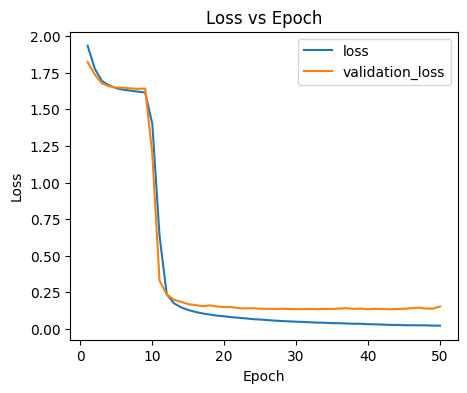

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(epoch, train_loss)
plt.plot(epoch, validation_loss)
plt.legend(["loss", "validation_loss"])
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

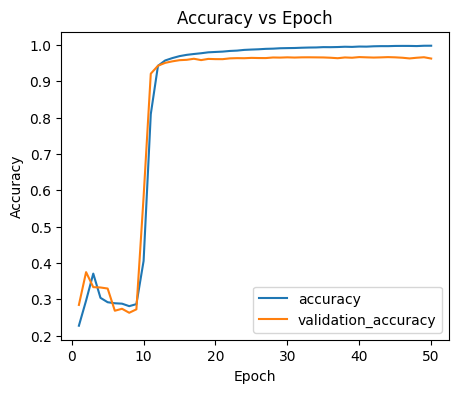

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(epoch, train_accuracy)
plt.plot(epoch, validation_accuracy)
plt.legend(["accuracy", "validation_accuracy"])
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [69]:
model.evaluate(test_images_flattened, one_hot_test_labels)

10000/10000 [==============================] runtime: 0.4913s, loss:0.1568, accuracy: 0.9625
[0.1568240154493295, 0.9625]


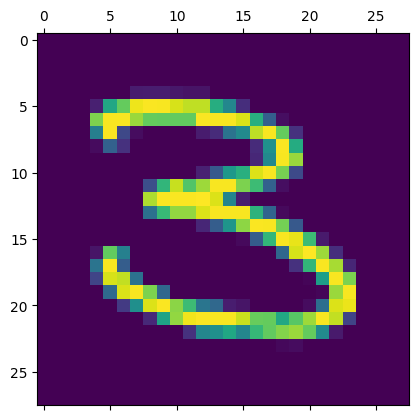

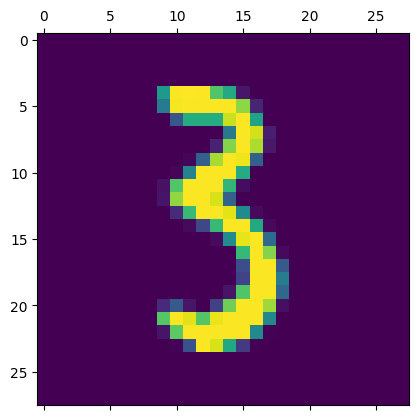

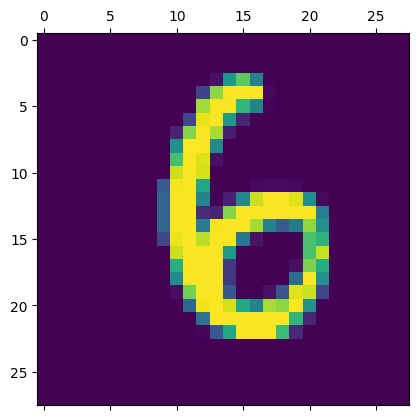

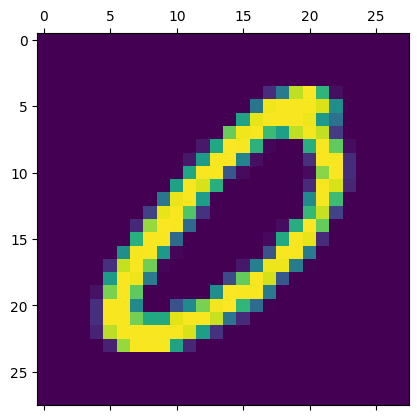

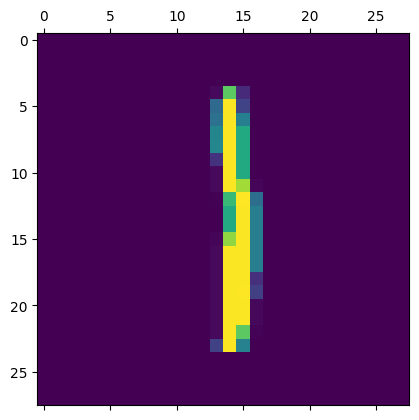

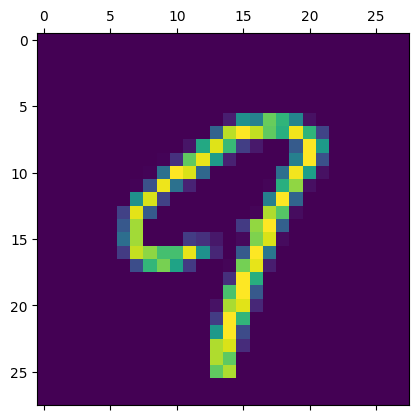

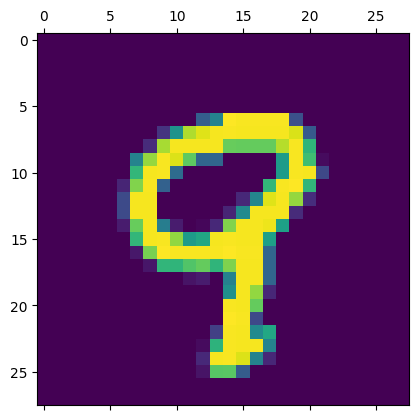

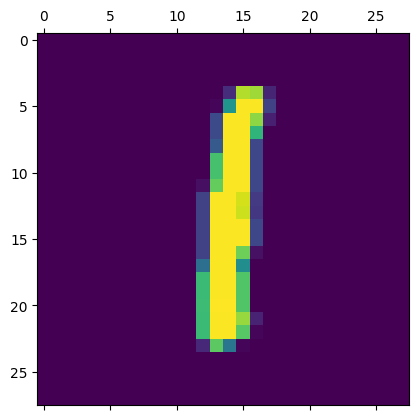

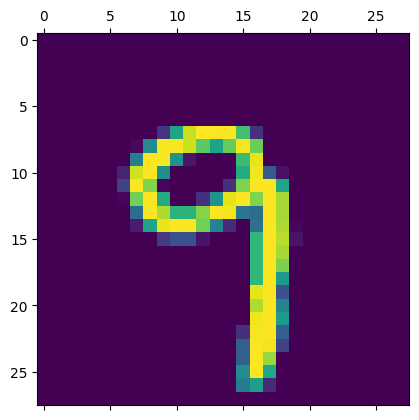

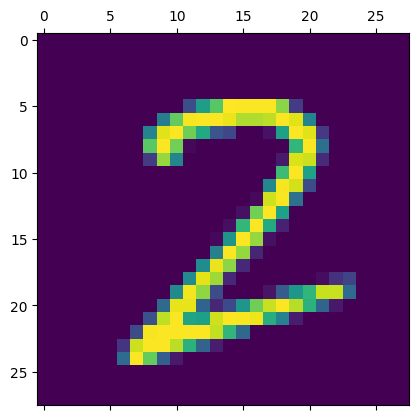

In [ ]:
images_labels = []
images_idx = []
for idx in np.random.randint(0,1000, size=10):
  images_labels.append(test_labels[idx])
  images_idx.append(idx)
  plt.matshow(test_images[idx])


In [ ]:
print(images_labels)

[3, 3, 6, 0, 1, 9, 9, 1, 9, 2]


In [ ]:
predicted_scores = model.predict(test_images_flattened)
predicted_scores

array([[1.37776003e-12, 7.15895272e-11, 5.04386769e-08, ...,
        9.99970729e-01, 1.24366065e-16, 1.42381226e-05],
       [4.40199355e-05, 1.16191069e-07, 9.91468150e-01, ...,
        1.77076020e-08, 4.10645190e-09, 6.27417836e-14],
       [2.61850984e-07, 9.99696019e-01, 1.59291488e-05, ...,
        1.64990792e-08, 2.24786038e-05, 9.41300560e-11],
       ...,
       [4.12776603e-08, 2.49295993e-18, 6.19247320e-10, ...,
        1.31422729e-08, 4.43842485e-10, 3.61214503e-04],
       [4.73749778e-04, 8.93362509e-10, 3.63510913e-06, ...,
        2.09306872e-22, 6.29159590e-03, 1.59277921e-21],
       [6.90857576e-12, 2.55332680e-08, 2.63163013e-08, ...,
        1.28945584e-06, 5.07465434e-17, 2.78738673e-18]])

In [ ]:
for i in images_idx:
  print("Predicted_value:", np.argmax(predicted_scores[i]),"  Actual_value:", test_labels[i])

Predicted_value: 3   Actual_value: 3
Predicted_value: 3   Actual_value: 3
Predicted_value: 6   Actual_value: 6
Predicted_value: 0   Actual_value: 0
Predicted_value: 1   Actual_value: 1
Predicted_value: 9   Actual_value: 9
Predicted_value: 9   Actual_value: 9
Predicted_value: 1   Actual_value: 1
Predicted_value: 9   Actual_value: 9
Predicted_value: 2   Actual_value: 2


In [ ]:
# confusion matrix
predicted_labels = np.array([np.argmax(i) for i in predicted_scores])
cm = tf.math.confusion_matrix(labels=test_labels, predictions=predicted_labels)
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 962,    0,    1,    1,    1,    6,    0,    0,    5,    4],
       [   0, 1118,    2,    4,    0,    2,    1,    0,    8,    0],
       [   7,    0,  999,    9,    1,    1,    2,    2,    9,    2],
       [   0,    2,   12,  972,    0,    0,    0,    1,   17,    6],
       [   3,    0,    3,    0,  930,    1,    2,    5,    4,   34],
       [   3,    1,   17,    2,    1,  828,    5,    0,   34,    1],
       [   2,    2,    4,    0,    3,   22,  922,    1,    2,    0],
       [   1,    1,   16,   21,    1,    0,    2,  957,    3,   26],
       [   1,    0,    2,    5,    0,    4,    0,    0,  954,    8],
       [   4,    1,    3,    2,    3,    0,    0,    0,   13,  983]],
      dtype=int32)>

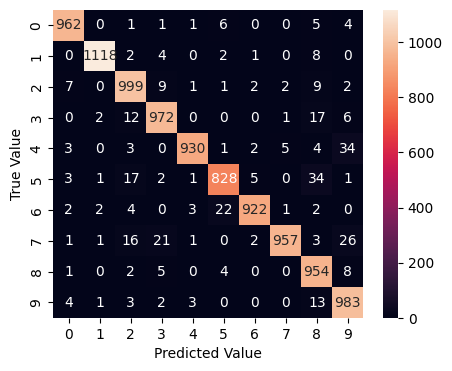

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted Value")
plt.ylabel("True Value")
plt.show()

In [ ]:
print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.94      0.97      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.99      0.95      0.97       982
           5       0.96      0.93      0.94       892
           6       0.99      0.96      0.97       958
           7       0.99      0.93      0.96      1028
           8       0.91      0.98      0.94       974
           9       0.92      0.97      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

